In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 32
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super(BasicConv2d, self).__init__()
        self.relu = relu
        if self.relu:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.features(x)
        return out

In [8]:
class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.feature = nn.Sequential(
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels, out_channels=bn_size * growth_rate,
                      kernel_size=1, stride=1,
                      bias=False),
            nn.BatchNorm2d(num_features=bn_size * growth_rate),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=bn_size * growth_rate, out_channels=growth_rate,
                      kernel_size=3, stride=1, padding=1,
                      bias=False),
        )
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = self.feature(x)
        if self.drop_rate > 0:
            new_features = F.dropout(input=new_features, p=self.drop_rate,
                                     training=self.training)
        return torch.cat([x, new_features], 1)

In [9]:
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, in_channels, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(in_channels=in_channels + i * growth_rate,
                                growth_rate=growth_rate, bn_size=bn_size, drop_rate=drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)

In [10]:
class _Transition(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_features=in_channels)),
        self.add_module('relu', nn.ReLU(inplace=True)),
        self.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                              kernel_size=1, stride=1, bias=False)),
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2)),

In [11]:
class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 in_channels=64, bn_size=4, drop_rate=0, num_classes=10):

        super(DenseNet, self).__init__()
        # 第一个卷积层
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(in_channels=3, out_channels=in_channels,
                                kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_features=in_channels)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # 每个denseblock
        self.num_features = in_channels
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, in_channels=self.num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            self.num_features = self.num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(
                    in_channels=self.num_features, out_channels=self.num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                self.num_features = self.num_features // 2

        #  batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features=self.num_features))

        # 分类器
        self.classifier = nn.Linear(in_features=self.num_features, out_features=num_classes)

    def forward(self, x):
        out = self.features(x)
        out = F.relu(out, inplace=True)
        out = F.adaptive_avg_pool2d(input=out, output_size=1).view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [12]:
def densenet121(**kwargs):
    model = DenseNet(in_channels=64, growth_rate=32, block_config=(6, 12, 24, 16), **kwargs)
    return model


def densenet169(**kwargs):
    model = DenseNet(in_channels=64, growth_rate=32, block_config=(6, 12, 32, 32), **kwargs)
    return model


def densenet201(**kwargs):
    model = DenseNet(in_channels=64, growth_rate=32, block_config=(6, 12, 48, 32), **kwargs)
    return model


def densenet161(**kwargs):
    model = DenseNet(in_channels=96, growth_rate=48, block_config=(6, 12, 36, 24), **kwargs)
    return model

In [13]:
net = densenet121().to(DEVICE)
# net = model.densenet121().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
       BatchNorm2d-5           [-1, 64, 56, 56]             128
              ReLU-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]           8,192
       BatchNorm2d-8          [-1, 128, 56, 56]             256
              ReLU-9          [-1, 128, 56, 56]               0
           Conv2d-10           [-1, 32, 56, 56]          36,864
      _DenseLayer-11           [-1, 96, 56, 56]               0
      BatchNorm2d-12           [-1, 96, 56, 56]             192
             ReLU-13           [-1, 96, 56, 56]               0
           Conv2d-14          [-1, 128,

In [16]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [17]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [18]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [19]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [20]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [21]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.322248
Train Epoch: 1 [3200/40000 (8%)]	Loss: 1.785786
Train Epoch: 1 [6400/40000 (16%)]	Loss: 1.965016
Train Epoch: 1 [9600/40000 (24%)]	Loss: 1.779144
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.550668
Train Epoch: 1 [16000/40000 (40%)]	Loss: 1.732754
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.535686
Train Epoch: 1 [22400/40000 (56%)]	Loss: 1.591572
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.328147
Train Epoch: 1 [28800/40000 (72%)]	Loss: 1.496729
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.323209
Train Epoch: 1 [35200/40000 (88%)]	Loss: 1.282391
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.463579
VAL set: Average loss: 0.046316, Accuracy: 4590.0/10000 (45.9%)
Validation loss decreased (inf --> 0.046316).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.705931
Train Epoch: 2 [3200/40000 (8%)]	Loss: 1.610380
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.501881
Train Epoch: 2 [9600/40000 (24%)]	Loss: 1.446805
Train Epoch: 2 [12800/40000 (32%)]	Loss

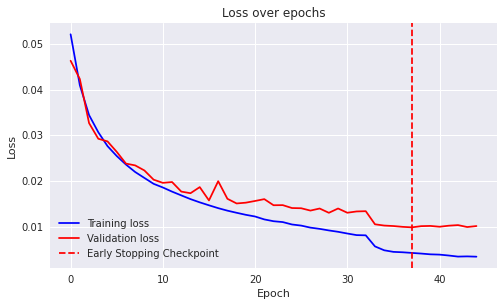

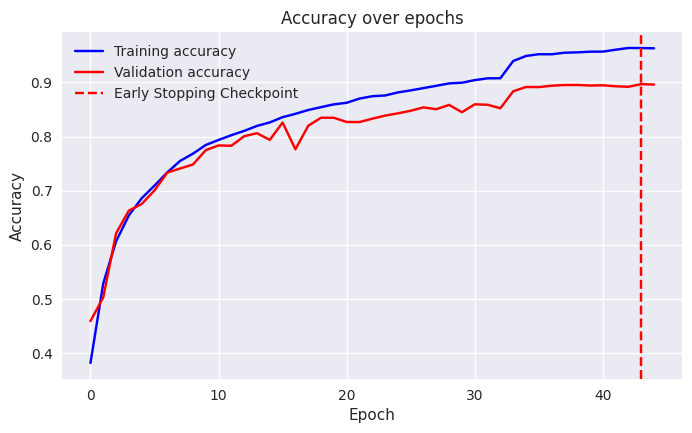

In [22]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'DenseNet - predictions')

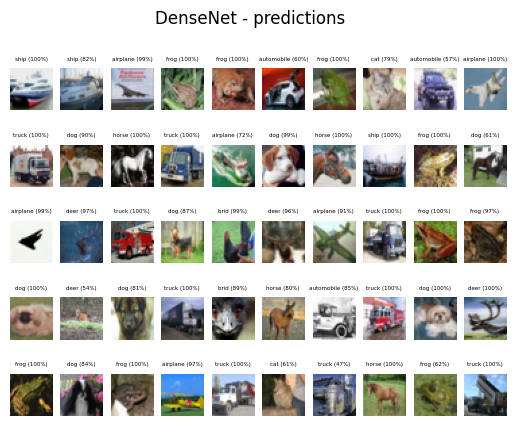

In [23]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('DenseNet - predictions')

In [ ]:
"""
DenseNet-121
Mine(batch_size = 32):
After 020 Epoch: 81.2%
After 040 Epoch: 86.9%
After 060 Epoch: 88.8%
After 080 Epoch: 90.7%
After 100 Epoch: 91.3%
structure:
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 96, 56, 56]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 128, 56, 56]         49,600
|    |    └─_DenseLayer: 3-3             [-1, 160, 56, 56]         53,760
|    |    └─_DenseLayer: 3-4             [-1, 192, 56, 56]         57,920
|    |    └─_DenseLayer: 3-5             [-1, 224, 56, 56]         62,080
|    |    └─_DenseLayer: 3-6             [-1, 256, 56, 56]         66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 28]         --
|    |    └─BatchNorm2d: 3-7             [-1, 256, 56, 56]         512
|    |    └─ReLU: 3-8                    [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-9                  [-1, 128, 56, 56]         32,768
|    |    └─AvgPool2d: 3-10              [-1, 128, 28, 28]         --
|    └─_DenseBlock: 2-7                  [-1, 512, 28, 28]         --
|    |    └─_DenseLayer: 3-11            [-1, 160, 28, 28]         53,760
|    |    └─_DenseLayer: 3-12            [-1, 192, 28, 28]         57,920
|    |    └─_DenseLayer: 3-13            [-1, 224, 28, 28]         62,080
|    |    └─_DenseLayer: 3-14            [-1, 256, 28, 28]         66,240
|    |    └─_DenseLayer: 3-15            [-1, 288, 28, 28]         70,400
|    |    └─_DenseLayer: 3-16            [-1, 320, 28, 28]         74,560
|    |    └─_DenseLayer: 3-17            [-1, 352, 28, 28]         78,720
|    |    └─_DenseLayer: 3-18            [-1, 384, 28, 28]         82,880
|    |    └─_DenseLayer: 3-19            [-1, 416, 28, 28]         87,040
|    |    └─_DenseLayer: 3-20            [-1, 448, 28, 28]         91,200
|    |    └─_DenseLayer: 3-21            [-1, 480, 28, 28]         95,360
|    |    └─_DenseLayer: 3-22            [-1, 512, 28, 28]         99,520
|    └─_Transition: 2-8                  [-1, 256, 14, 14]         --
|    |    └─BatchNorm2d: 3-23            [-1, 512, 28, 28]         1,024
|    |    └─ReLU: 3-24                   [-1, 512, 28, 28]         --
|    |    └─Conv2d: 3-25                 [-1, 256, 28, 28]         131,072
|    |    └─AvgPool2d: 3-26              [-1, 256, 14, 14]         --
|    └─_DenseBlock: 2-9                  [-1, 1024, 14, 14]        --
|    |    └─_DenseLayer: 3-27            [-1, 288, 14, 14]         70,400
|    |    └─_DenseLayer: 3-28            [-1, 320, 14, 14]         74,560
|    |    └─_DenseLayer: 3-29            [-1, 352, 14, 14]         78,720
|    |    └─_DenseLayer: 3-30            [-1, 384, 14, 14]         82,880
|    |    └─_DenseLayer: 3-31            [-1, 416, 14, 14]         87,040
|    |    └─_DenseLayer: 3-32            [-1, 448, 14, 14]         91,200
|    |    └─_DenseLayer: 3-33            [-1, 480, 14, 14]         95,360
|    |    └─_DenseLayer: 3-34            [-1, 512, 14, 14]         99,520
|    |    └─_DenseLayer: 3-35            [-1, 544, 14, 14]         103,680
|    |    └─_DenseLayer: 3-36            [-1, 576, 14, 14]         107,840
|    |    └─_DenseLayer: 3-37            [-1, 608, 14, 14]         112,000
|    |    └─_DenseLayer: 3-38            [-1, 640, 14, 14]         116,160
|    |    └─_DenseLayer: 3-39            [-1, 672, 14, 14]         120,320
|    |    └─_DenseLayer: 3-40            [-1, 704, 14, 14]         124,480
|    |    └─_DenseLayer: 3-41            [-1, 736, 14, 14]         128,640
|    |    └─_DenseLayer: 3-42            [-1, 768, 14, 14]         132,800
|    |    └─_DenseLayer: 3-43            [-1, 800, 14, 14]         136,960
|    |    └─_DenseLayer: 3-44            [-1, 832, 14, 14]         141,120
|    |    └─_DenseLayer: 3-45            [-1, 864, 14, 14]         145,280
|    |    └─_DenseLayer: 3-46            [-1, 896, 14, 14]         149,440
|    |    └─_DenseLayer: 3-47            [-1, 928, 14, 14]         153,600
|    |    └─_DenseLayer: 3-48            [-1, 960, 14, 14]         157,760
|    |    └─_DenseLayer: 3-49            [-1, 992, 14, 14]         161,920
|    |    └─_DenseLayer: 3-50            [-1, 1024, 14, 14]        166,080
|    └─_Transition: 2-10                 [-1, 512, 7, 7]           --
|    |    └─BatchNorm2d: 3-51            [-1, 1024, 14, 14]        2,048
|    |    └─ReLU: 3-52                   [-1, 1024, 14, 14]        --
|    |    └─Conv2d: 3-53                 [-1, 512, 14, 14]         524,288
|    |    └─AvgPool2d: 3-54              [-1, 512, 7, 7]           --
|    └─_DenseBlock: 2-11                 [-1, 1024, 7, 7]          --
|    |    └─_DenseLayer: 3-55            [-1, 544, 7, 7]           103,680
|    |    └─_DenseLayer: 3-56            [-1, 576, 7, 7]           107,840
|    |    └─_DenseLayer: 3-57            [-1, 608, 7, 7]           112,000
|    |    └─_DenseLayer: 3-58            [-1, 640, 7, 7]           116,160
|    |    └─_DenseLayer: 3-59            [-1, 672, 7, 7]           120,320
|    |    └─_DenseLayer: 3-60            [-1, 704, 7, 7]           124,480
|    |    └─_DenseLayer: 3-61            [-1, 736, 7, 7]           128,640
|    |    └─_DenseLayer: 3-62            [-1, 768, 7, 7]           132,800
|    |    └─_DenseLayer: 3-63            [-1, 800, 7, 7]           136,960
|    |    └─_DenseLayer: 3-64            [-1, 832, 7, 7]           141,120
|    |    └─_DenseLayer: 3-65            [-1, 864, 7, 7]           145,280
|    |    └─_DenseLayer: 3-66            [-1, 896, 7, 7]           149,440
|    |    └─_DenseLayer: 3-67            [-1, 928, 7, 7]           153,600
|    |    └─_DenseLayer: 3-68            [-1, 960, 7, 7]           157,760
|    |    └─_DenseLayer: 3-69            [-1, 992, 7, 7]           161,920
|    |    └─_DenseLayer: 3-70            [-1, 1024, 7, 7]          166,080
|    └─BatchNorm2d: 2-12                 [-1, 1024, 7, 7]          2,048
├─Linear: 1-2                            [-1, 10]                  10,250
==========================================================================================
Total params: 6,964,106
Trainable params: 6,964,106
Non-trainable params: 0
Total mult-adds (M): 452.55
==========================================================================================
Input size (MB): 0.57
Forward/backward pass size (MB): 28.71
Params size (MB): 26.57
Estimated Total Size (MB): 55.85
==========================================================================================
parameters_count: 6964106

Pytorch(batch_size = 32):
After 020 Epoch: 81.6%
After 040 Epoch: 85.0%
After 060 Epoch: 87.9%
After 080 Epoch: 89.1%
After 100 Epoch: 89.1%
"""